<a href="https://colab.research.google.com/github/komazawa-deep-learning/komazawa-deep-learning.github.io/blob/master/2023notebooks/2023_0602Transformer_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%config InlineBackend.figure_format = 'retina'
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

from IPython import get_ipython
isColab =  'google.colab' in str(get_ipython())

# PyTorch による Transformer の実装

このチュートリアルでは PyTorch を使用して基本的な Transformer モデルをゼロから構築する。
Transformer モデルは Vaswani+ が論文 [Attention is All You Need](https://arxiv.org/abs/1706.03762) で導入したもので，機械翻訳やテキスト要約などの seq2seq 課題のために設計された深層学習アーキテクチャである。
自己注意機構に基づいており，GPT や BERT など，多くの最先端の自然言語処理モデルの基盤となっている。

Transformer モデルの作成においては以下の段階を踏む:

1. 必要なライブラリやモジュールの輸入
2. 基本的な構成要素を定義: マルチヘッド注意，位置ごとのフィードフォワードネットワーク，位置符号化器
3. 符号化器と復号化器の層の定義
4. 符号化器と復号化器の層を組み合わせて，完全な transformer モデルを実装
5. サンプルデータの作成
6. モデルの訓練

以下，順を追って説明する。
 

## 1. 必要なライブラリやモジュールの輸入


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import math
import copy

## 2. Transformer モデルの基本的な構成要素の定義

### 2.1. マルチヘッド注意

マルチヘッド注意機構は，系列内の各対の位置間の注意を計算する。
これは，入力系列の異なる側面を捉える複数の `注意ヘッド` で構成される。


In [ ]:
class MultiHeadAttention(nn.Module):
    """
    このコードは，入力パラメータと線形変換層でモジュールを初期化し，
    注意得点を計算し，入力テンソルを複数のヘッドに再整形し，すべてのヘッドからの注意出力を結合する。
    `forward()` はマルチヘッド自己注意を計算し，モデルが入力系列の別の面に注意を向けることを可能にする。
    """
    def __init__(self, 
                 d_model:int,    # 各層の素子数
                 num_heads:int   # ヘッド数，マルチヘッド注意の定義に必要
                ):
        super().__init__()
        assert d_model % num_heads == 0, "d_model は num_heads で割り切れる数である必要がある"
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        
        # クエリ行列
        self.W_q = nn.Linear(in_features=d_model, out_features=d_model)

        # キー行列
        self.W_k = nn.Linear(in_features=d_model, out_features=d_model)

        # バリュー行列
        self.W_v = nn.Linear(in_features=d_model, out_features=d_model)

        # 出力行列
        self.W_o = nn.Linear(in_features=d_model, out_features=d_model)
        
    def scaled_dot_product_attention(self, 
                                     Q:torch.Tensor, 
                                     K:torch.Tensor, 
                                     V:torch.Tensor, 
                                     mask=None):
        """規格化したドット積注意"""

        # クエリ行列とキー行列をかけて注意得点を算出，K.transpose(-2,-1) は行列の転置
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)

        if mask is not None:  # マスクをかける
            attn_scores = attn_scores.masked_fill(mask==0, -1e9)

        # 注意得点にソフトマックスをかける
        attn_probs = torch.softmax(attn_scores, dim=-1)

        # ソフトマックスにかけた注意得点に対して，バリュー行列をかけて出力を計算
        output = torch.matmul(attn_probs, V)
        return output
        
    def split_heads(self, 
                    x:torch.Tensor):
        """注意のヘッドを分割"""
        # 入力データ x の次元から，バッチサイズ，系列長，モデルの素子数を算出
        batch_size, seq_length, d_model = x.size()

        # 入力データを分割して返す
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)
        
    def combine_heads(self, 
                      x:torch.Tensor):
        """分割したヘッドを統合"""
        batch_size, _, seq_length, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)
        
    def forward(self, 
                Q:torch.Tensor, 
                K:torch.Tensor, 
                V:torch.Tensor, mask=None):
        """マルチヘッド注意の順向処理"""
        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))
        
        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)
        output = self.W_o(self.combine_heads(attn_output))
        return output


### 2.2 位置ごとのフィードフォワードネットワーク <!--Position-wise_FeedForward_Networks-->

In [ ]:
class PositionWiseFeedForward(nn.Module):
    """
    PyTorch の `nn.Module` を拡張した，位置毎のフィードフォワードネットワークの実装
    このクラスは，2 つの線形変換層と整流線形化 (ReLU) 活性化関数で初期化される。
    `forward()` は，これらの変換と活性化関数を順次適用して出力を計算する。
    この処理により，モデルは入力要素の位置を考慮しながら予測を行うことができる。
    """
    def __init__(self, 
                 d_model:int, 
                 d_ff:int):
        super().__init__()
        self.fc1 = nn.Linear(in_features=d_model, out_features=d_ff)
        self.fc2 = nn.Linear(in_features=d_ff, out_features=d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x


### 2.3 位置符号化器 Positional Encoding

位置符号化は，入力系列の各トークンの位置情報を挿入するために使用される。
異なる周波数の正弦波関数と余弦波関数を使用して位置情報を生成する。


In [ ]:
class PositionalEncoding(nn.Module):
    """
    入力パラメータ `d_model` と `max_seq_length` で初期化し，位置符号化器の値を格納するテンソルを作成する。
    このクラスは，スケール因子 `div_term` に基づいて，偶数インデックスと奇数インデックスの正弦波と余弦波の値をそれぞれ計算する。
    `forward()` は，格納された位置符号化値を入力テンソルに追加することで位置符号化を計算し，モデルが入力配列の位置情報を捕捉できるようにする。

    位置符号化では，位置に応じて正弦波が加算される。
    周波数とオフセットは，各次元で異なる。
    """
    def __init__(self, 
                 d_model:int, 
                 max_seq_length:int):
        super().__init__()
        
        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        self.register_buffer('pe', pe.unsqueeze(0))
        
    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

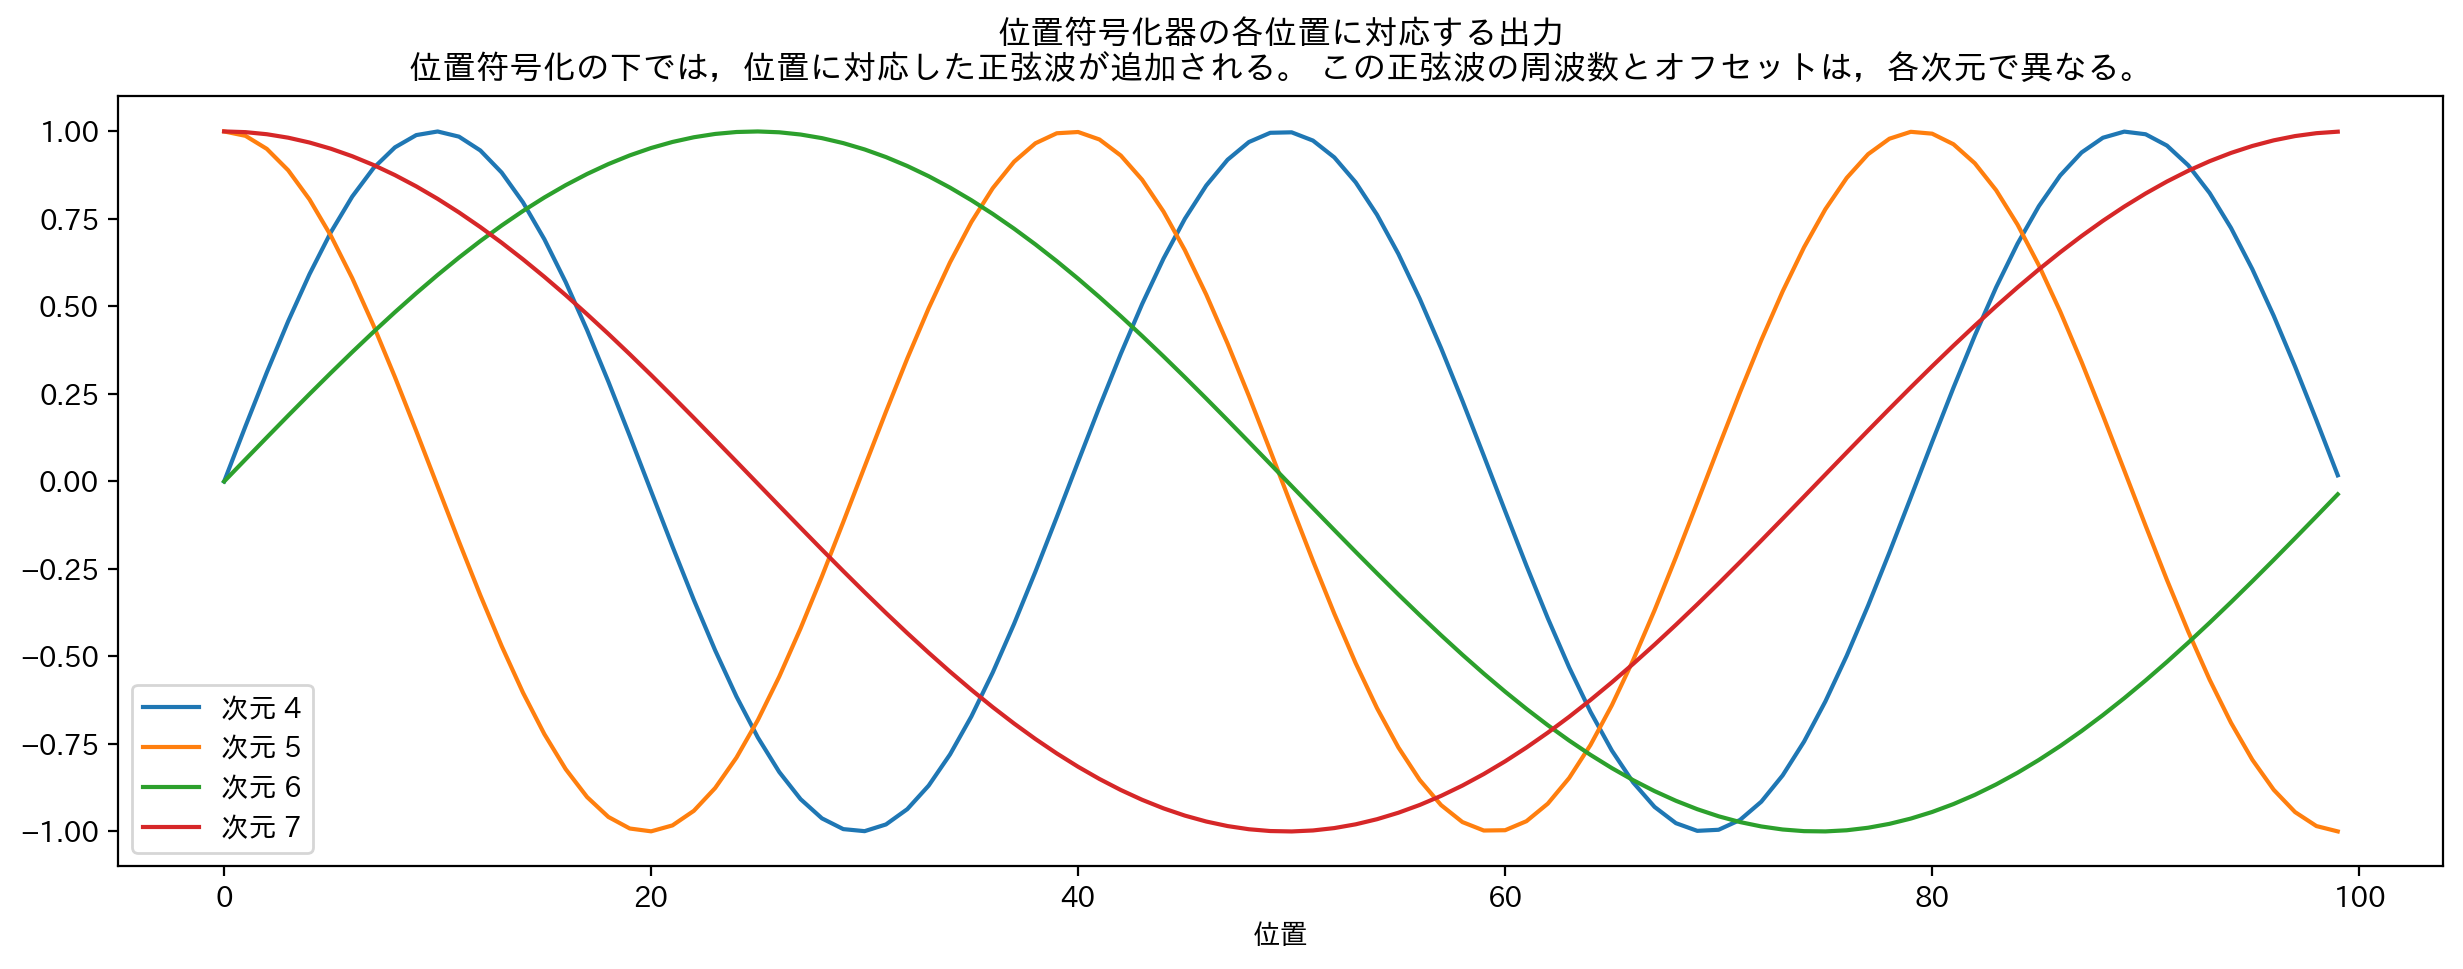

In [ ]:
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
try:
    import japanize_matplotlib
except ImportError:
    !pip install japanize_matplotlib
    import japanize_matplotlib
    
plt.figure(figsize=(15, 5))
pe = PositionalEncoding(d_model=20, max_seq_length=500)
y = pe.forward(Variable(torch.zeros(1, 100, 20)))
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend([f"次元 {p}" for p in [4,5,6,7]])
plt.title('位置符号化器の各位置に対応する出力\n位置符号化の下では，位置に対応した正弦波が追加される。 この正弦波の周波数とオフセットは，各次元で異なる。')
plt.xlabel('位置')
plt.show()

## 3. 符号化器層 Encoder Layer

<center>
<img src="https://miro.medium.com/v2/resize:fit:552/format:webp/0*bPKV4ekQr9ZjYkWJ.png" width="18%"><br/>
図 Transformer ネットワークの符号化器部分
</center>

符号化器層は，マルチヘッド注意層，位置ごとのフィードフォワード層，2 つの層正規化層で構成される。


In [ ]:
class EncoderLayer(nn.Module):
    """
    入力パラメータと，`MultiHeadAttention` モジュール，
    `PositionWiseFeedForward` モジュール，
    2 つの層正規化モジュール，ドロップアウト層などの成分で初期化。
    `forward()` は，自己注意を適用して符号化層の出力を計算し，注意出力を入力テンソルに加え，その結果を正規化する。
    次に，位置ごとのフィードフォワード出力を計算し，正規化された自己注意出力と結合し，最終結果を正規化してから処理されたテンソルを返す。
    """
    def __init__(self, d_model, num_heads, d_ff, dropout):
        
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, mask):
        attn_output = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x

## 4. 復号化器層 Decoder Layer

<center>
<img src="https://miro.medium.com/v2/resize:fit:552/format:webp/0*SPZgT4k8GQi37H__.png" width="18%"><br/>
図 4. Transformer ネットワークの復号化器部分    
<!-- Figure 4. The Decoder part of the Transformer network (Souce: Image from the original paper) -->
</center>

復号化器層は，2 つのマルチヘッド注意層，位置ごとのフィードフォワード層，3 つの層正規化層で構成される。
<!-- A Decoder layer consists of two Multi-Head Attention layers, a Position-wise Feed-Forward layer, and three Layer Normalization layers. -->

In [ ]:
class DecoderLayer(nn.Module):
    """
    入力パラメータと，マスクされた自己注意と交差注意のためのマルチヘッド注意モジュール，
    位置ごとのフィードフォワードモジュール，3  層の正規化モジュール，およびドロップアウト層などの成分で初期化

    `forward()`は，以下のステップを実行することで，復号化器層の出力を計算する:
    1. マスクされた自己注意出力を計算し，入力テンソルに加算した後，ドロップアウトと層正規化を行う。
    2. 復号化器出力と符号化器出力の間の交差注意出力を計算し，正規化されたマスクされた自己注意出力に加え，ドロップアウトと層正規化を行う。
    3. 位置ごとのフィードフォワード出力を計算し，正規化された交差注意出力に加え，ドロップアウトと層正規化を行う。
    4. 処理されたテンソルを返す。

    これらにより，復号化は入力と符号化出力に基づいて標的系列を生成する
    """
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super().__init__()
        
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, enc_output, src_mask, tgt_mask):
        attn_output = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(attn_output))
        attn_output = self.cross_attn(x, enc_output, enc_output, src_mask)
        x = self.norm2(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout(ff_output))
        return x

## 5. 符号化器と復号化器の層を組み合わせて，Transformer モデルの実装

<center>
<img src="https://miro.medium.com/v2/resize:fit:1090/format:webp/0*ljYs7oOlKC71SzSr.png" width="33%"><br/>
Figure 5. The Transformer Network (Source: Image from the original paper)
</center>



In [ ]:
class Transformer(nn.Module):
    """
    上で定義したモジュールを組み合わせて，Transformer モデルを定義
    初期化の際 Transformer モジュールは入力パラメータを設定し，ソース系列とターゲット系列用の埋め込み層，
    PositionalEncoding モジュール，スタック層を定義している。
    EncoderLayer と DecoderLayer モジュール，復号化器出力を射影する線形層，ドロップアウト層など様々な成分を初期化。

    `generate_mask()` は，パディングトークンを無視し，復号化器が将来のトークンに注目しないように，ソースとターゲット系列に二値化マスクを作成する。

    `forward()`ドは，以下のステップで Transformer モデルの出力を計算する：
    
    1. `generate_mask()` でソースマスクとターゲットマスクを生成
    2. ソースとターゲットの埋め込みを計算し，位置符号化とドロップアウトを適用
    3. ソース系列を符号化層で処理し enc_output テンソルを更新
    4. 符号化出力とマスクを用いて ターゲット系列を復号化器層で処理し，`dec_output` テンソルを更新
    5. 復号化器出力に線形射影層を適用し，出力ロジットを算出

    これらにより Transformer モデルは，成分の組み合わせ機能に基づいて，入力系列を処理し，出力系列を生成する
    """
    def __init__(self, 
                 src_vocab_size, 
                 tgt_vocab_size, 
                 d_model, 
                 num_heads, 
                 num_layers, 
                 d_ff, 
                 max_seq_length, 
                 dropout):
        super().__init__()
        self.encoder_embedding = nn.Embedding(src_vocab_size, d_model)
        self.decoder_embedding = nn.Embedding(tgt_vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)

        self.encoder_layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.decoder_layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])

        self.fc = nn.Linear(d_model, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def generate_mask(self, src, tgt):
        src_mask = (src != 0).unsqueeze(1).unsqueeze(2)
        tgt_mask = (tgt != 0).unsqueeze(1).unsqueeze(3)
        seq_length = tgt.size(1)
        nopeak_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length), diagonal=1)).bool()
        tgt_mask = tgt_mask & nopeak_mask
        return src_mask, tgt_mask

    def forward(self, src, tgt):
        src_mask, tgt_mask = self.generate_mask(src, tgt)
        src_embedded = self.dropout(self.positional_encoding(self.encoder_embedding(src)))
        tgt_embedded = self.dropout(self.positional_encoding(self.decoder_embedding(tgt)))

        enc_output = src_embedded
        for enc_layer in self.encoder_layers:
            enc_output = enc_layer(enc_output, src_mask)

        dec_output = tgt_embedded
        for dec_layer in self.decoder_layers:
            dec_output = dec_layer(dec_output, enc_output, src_mask, tgt_mask)

        output = self.fc(dec_output)
        return output


## 6. サンプルデータの準備

この例では，デモ用におもちゃのデータセットを作成する。
実際には，より大きなデータセットを使用し，テキストを前処理し，ソース言語とターゲット言語の語彙写像を作成することになる。

In [ ]:
src_vocab_size = 5000
tgt_vocab_size = 5000
d_model = 512
num_heads = 8
num_layers = 6
d_ff = 2048
max_seq_length = 100
dropout = 0.1

transformer = Transformer(src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout)

# サンプルデータの生成
src_data = torch.randint(1, src_vocab_size, (64, max_seq_length))  # (batch_size, seq_length)
tgt_data = torch.randint(1, tgt_vocab_size, (64, max_seq_length))  # (batch_size, seq_length)

## 7. モデルの訓練

では，サンプルデータを使ってモデルを訓練してみよう。
実際には，もっと大きなデータセットを使って，訓練セットと検証セットに分けることになる。

In [ ]:
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

transformer.train()

for epoch in range(100):
    optimizer.zero_grad()
    output = transformer(src_data, tgt_data[:, :-1])
    loss = criterion(output.contiguous().view(-1, tgt_vocab_size), tgt_data[:, 1:].contiguous().view(-1))
    loss.backward()
    optimizer.step()
    print(f"Epoch: {epoch+1:3d}, Loss: {loss.item():.3f}")

このコードにより Pytorch でゼロから簡単な Transformer を構築することが可能である。

すべての大規模言語モデル (LLM) は，この Transformer 符号器または復号化器ブロックを学習に使用している。
したがって，すべてを開始したネットワークを理解することは非常に重要である。
